<a href="https://colab.research.google.com/github/andysingal/deep-learning/blob/main/Tensorflow_basics/CNN/notebooks/CNN1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import tensorflow as tf
from tensorflow.keras.datasets.mnist import load_data
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K
%matplotlib inline

def fix_random_seed(seed):
    """ Setting the random seed of various libraries """
    try:
        np.random.seed(seed)
    except NameError:
        print("Warning: Numpy is not imported. Setting the seed for Numpy failed.")
    try:
        tf.random.set_seed(seed)
    except NameError:
        print("Warning: TensorFlow is not imported. Setting the seed for TensorFlow failed.")
    try:
        random.seed(seed)
    except NameError:
        print("Warning: random module is not imported. Setting the seed for random failed.")
   
# Fixing the random seed
fix_random_seed(4321)
print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.12.0


# Convolutional Layers
The most important building block of a CNN is the convolutional layer:⁠6 neurons in the first convolutional layer are not connected to every single pixel in the input image (like they were in the layers discussed in previous chapters), but only to pixels in their receptive fields (see Figure 14-2). In turn, each neuron in the second convolutional layer is connected only to neurons located within a small rectangle in the first layer. 

In order for a layer to have the same height and width as the previous layer, it is common to add zeros around the inputs, as shown in the diagram. This is called zero padding.

This dramatically reduces the model’s computational complexity. The horizontal or vertical step size from one receptive field to the next is called the stride

I have represented the output of each convolutional layer as a 2D layer, but in reality a convolutional layer has multiple filters (you decide how many) and outputs one feature map per filter, so it is more accurately represented in 3D (see Figure 14-6). It has one neuron per pixel in each feature map, and all neurons within a given feature map share the same parameters (i.e., the same kernel and bias term). 

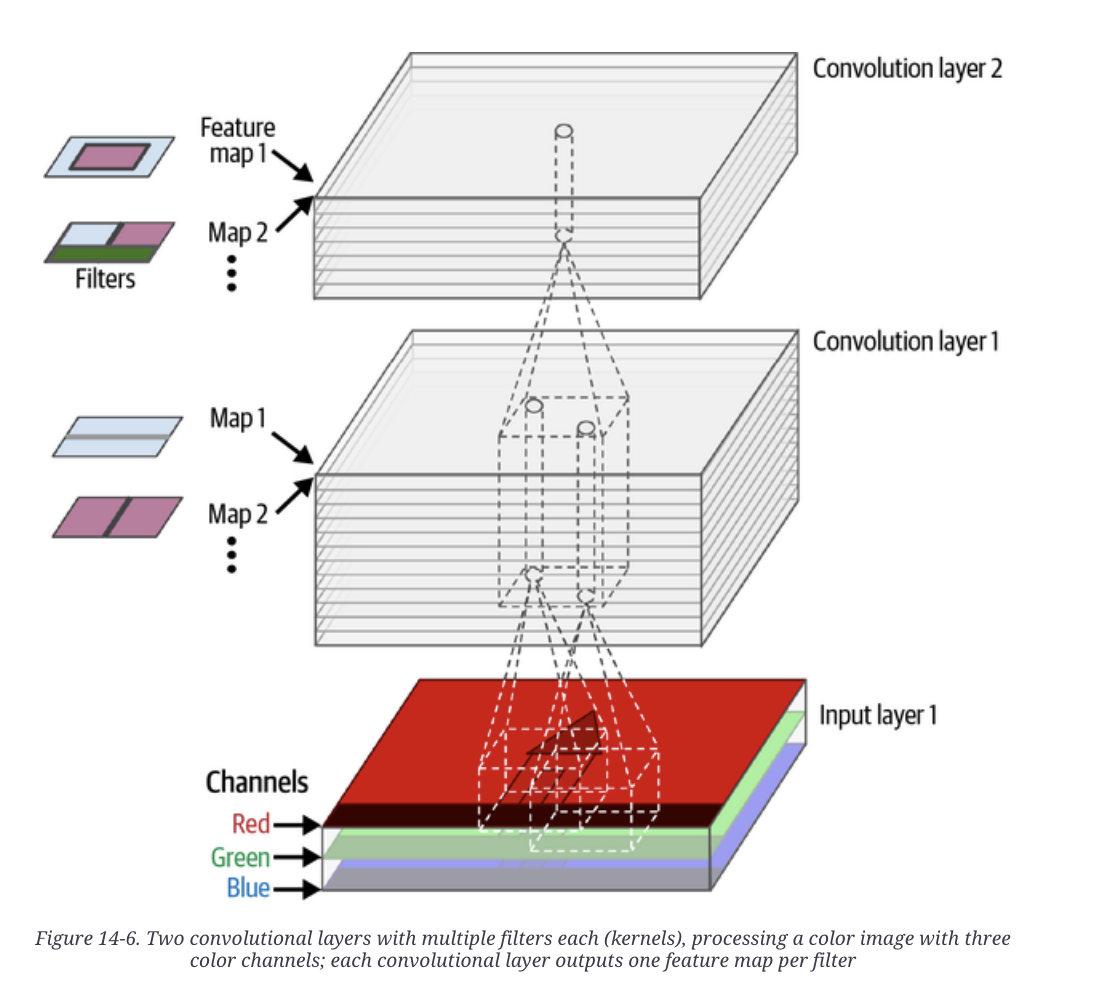

In [2]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

tf.random.set_seed(42)  # extra code – ensures reproducibility
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

fmaps.shape

TensorShape([2, 64, 114, 32])

The output shape is similar to the input shape, with two main differences. First, there are 32 channels instead of 3. This is because we set filters=32, so we get 32 output feature maps: instead of the intensity of red, green, and blue at each location, we now have the intensity of each feature at each location. Second, the height and width have both shrunk by 6 pixels. This is due to the fact that the Conv2D layer does not use any zero-padding by default, which means that we lose a few pixels on the sides of the output feature maps, depending on the size of the filters. In this case, since the kernel size is 7, we lose 6 pixels horizontally and 6 pixels vertically (i.e., 3 pixels on each side).

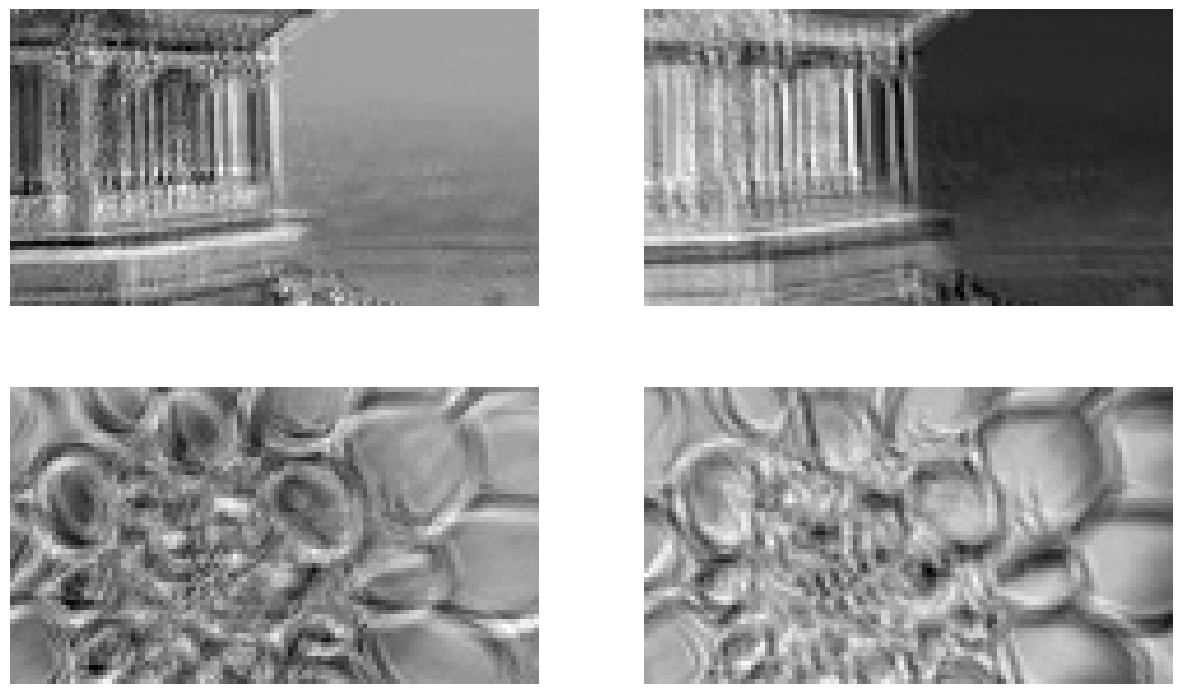

In [3]:
plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

If the stride is greater than 1 (in any direction), then the output size will not be equal to the input size, even if padding="same". For example, if you set strides=2 (or equivalently strides=(2, 2)), then the output feature maps will be 35 × 60: halved both vertically and horizontally. Figure 14-8 shows what happens when strides=2, with both padding options.

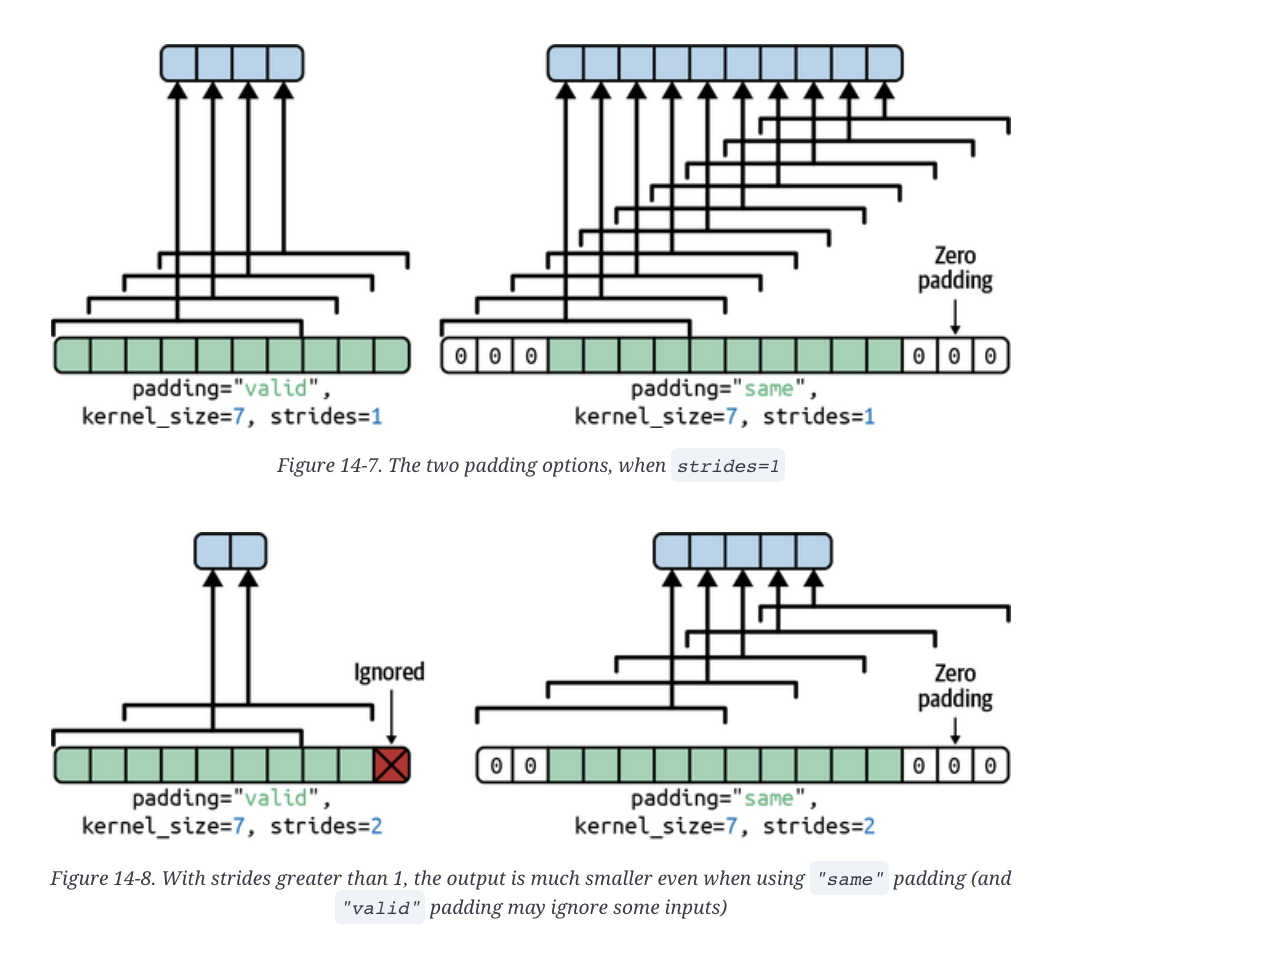

If you are curious, this is how the output size is computed:

- With padding="valid", if the width of the input is ih, then the output width is equal to (ih – fh + sh) / sh, rounded down. Recall that fh is the kernel width, and sh is the horizontal stride. Any remainder in the division corresponds to ignored columns on the right side of the input image. The same logic can be used to compute the output height, and any ignored rows at the bottom of the image.

- With padding="same", the output width is equal to ih / sh, rounded up. To make this possible, the appropriate number of zero columns are padded to the left and right of the input image (an equal number if possible, or just one more on the right side). Assuming the output width is ow, then the number of padded zero columns is (ow – 1) × sh + fh – ih. Again, the same logic can be used to compute the output height and the number of padded rows.

In [4]:
import numpy as np

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="same")

(array([35, 60]), array([5, 5]))

In [5]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

In [6]:
tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 3, 2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

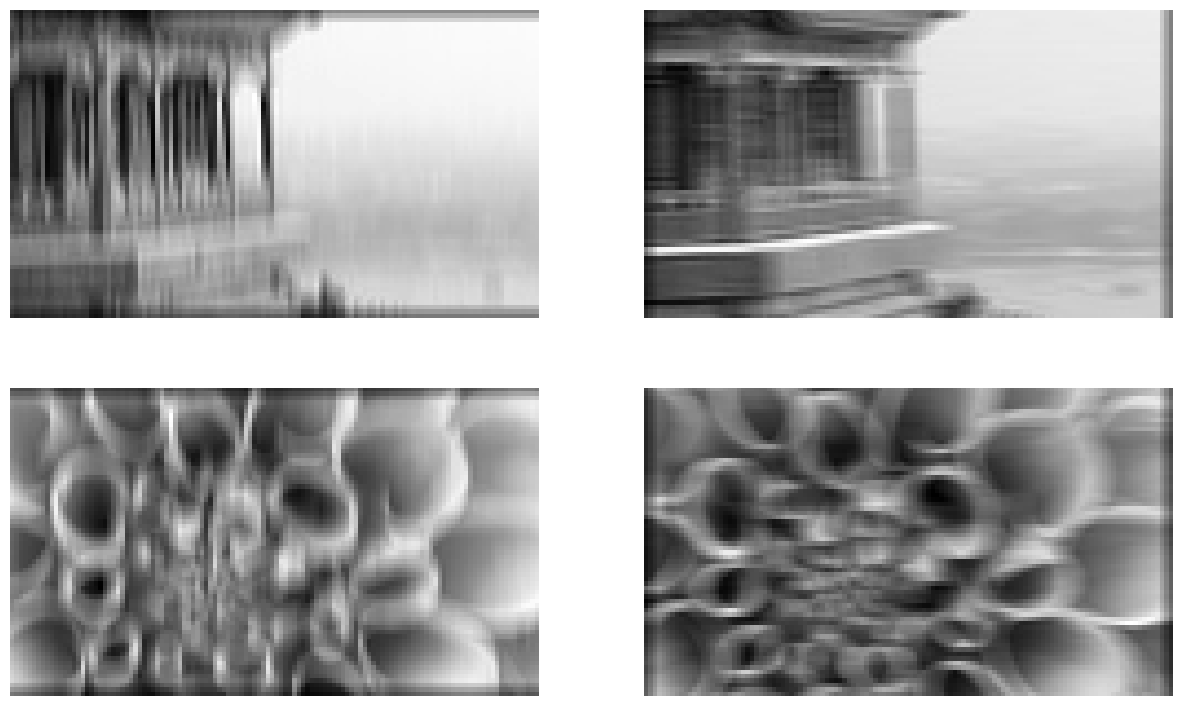

In [7]:
# extra code – shows how to manually create two filters to get images similar
#              to those in Figure 14–5.

plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

#POOLING

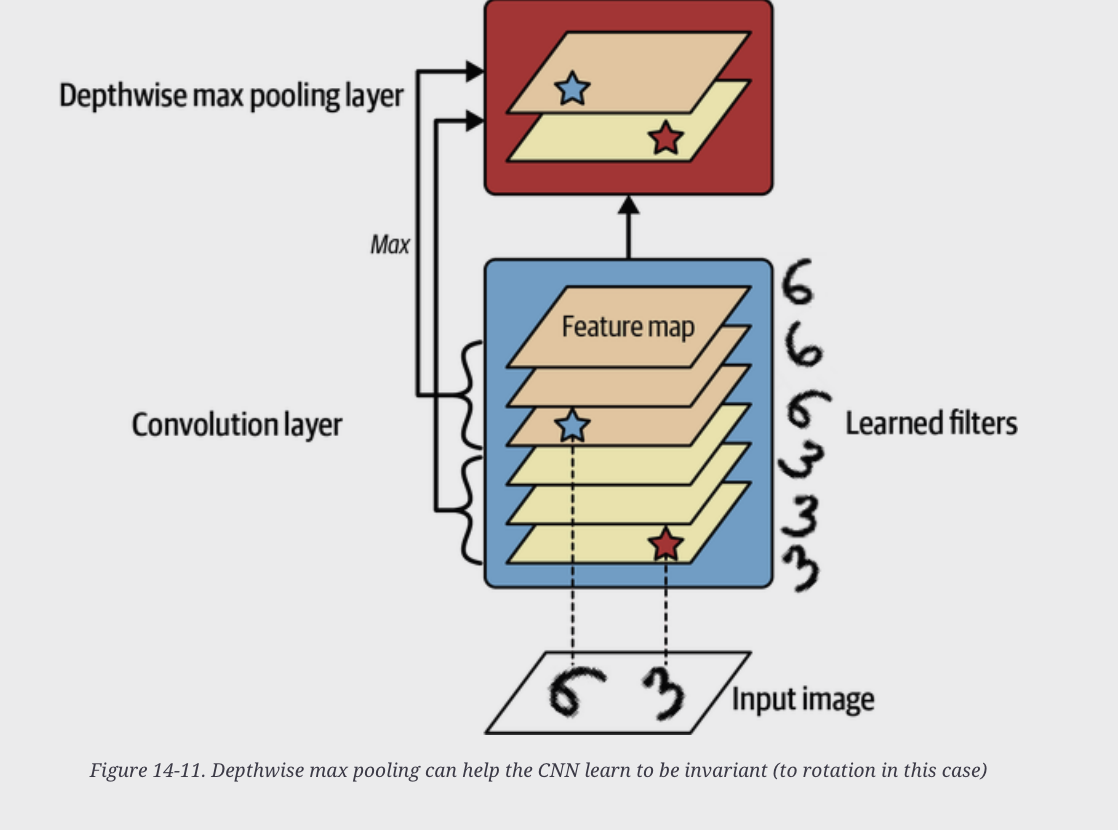

In [8]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [9]:
output = max_pool(images)

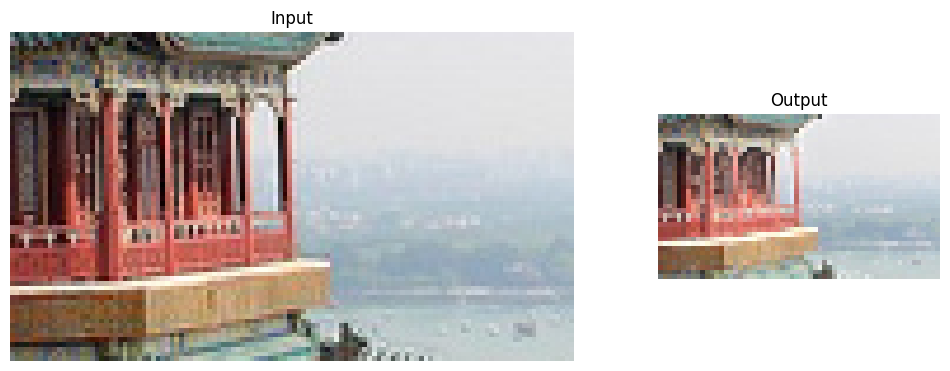

In [10]:
# extra code – this cells shows what max pooling with stride = 2 looks like

import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

In [11]:
# extra code – shows how to use the max_pool() op; only works on the CPU
np.random.seed(42)
fmaps = np.random.rand(2, 70, 120, 60)
with tf.device("/cpu:0"):
    output = tf.nn.max_pool(fmaps, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3),
                            padding="VALID")
output.shape


TensorShape([2, 70, 120, 20])

One last type of pooling layer that you will often see in modern architectures is the global average pooling layer. It works very differently: all it does is compute the mean of each entire feature map (it’s like an average pooling layer using a pooling kernel with the same spatial dimensions as the inputs). This means that it just outputs a single number per feature map and per instance. Although this is of course extremely destructive (most of the information in the feature map is lost), it can be useful just before the output layer, as you will see later in this chapter. To create such a layer, simply use the GlobalAveragePooling2D class, alias GlobalAvgPool2D

In [12]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

global_avg_pool = tf.keras.layers.Lambda(
    lambda X: tf.reduce_mean(X, axis=[1, 2]))

global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.64338624, 0.5971759 , 0.5824972 ],
       [0.76306933, 0.26011038, 0.10849128]], dtype=float32)>